In [1]:
import os

os.chdir(os.path.expanduser(os.path.split(os.path.abspath(""))[0]))

In [2]:
from src.dataset import ShapePairDataset
from src.plots import visualize_dataset_samples

# Датасет

/workspace/classification/src/plots.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


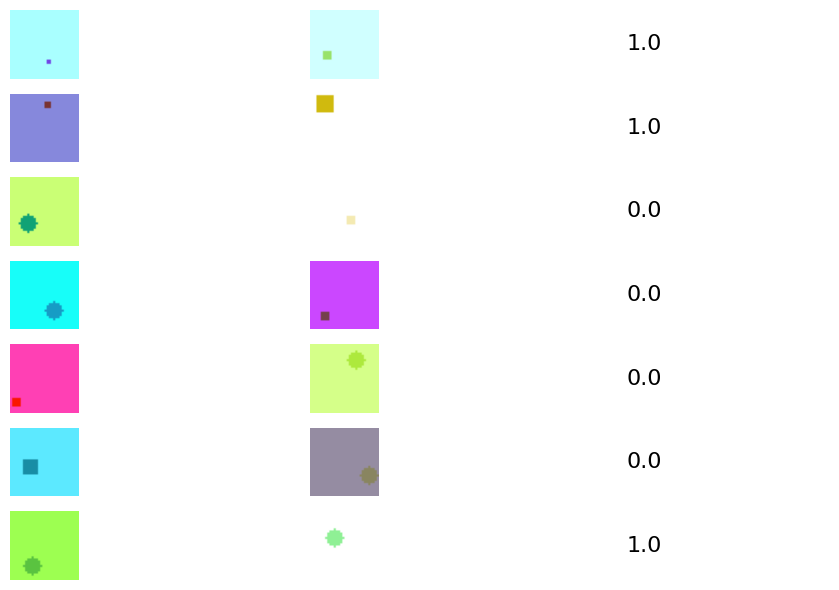

In [3]:
example_dataset = ShapePairDataset(num_samples=100)
visualize_dataset_samples(example_dataset, 7)

# Модель

In [4]:
from datetime import datetime
from pathlib import Path

import mlflow
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm.notebook import tqdm

In [5]:
from src.modeling.models import AGFusionModel
from src.modeling.train import train_epoch, validate_epoch

In [6]:
model = AGFusionModel()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
summary(model, [(3, 32, 32), (3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
         Identity-10             [-1, 64, 8, 8]               0
             ReLU-11             [-1, 64, 8, 8]               0
         Identity-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [9]:
BATCH_SIZE = 512
EMBEDDING_SIZE = 512
MARGIN = 1.0
LR = 3e-4
EPOCHS = 350
PATIENCE = 10

train_dataset = ShapePairDataset(num_samples=100000)
val_dataset = ShapePairDataset(10000)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## Обучение

In [ ]:
model = AGFusionModel()
# criterion = ContrastiveLoss(margin=MARGIN)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

progress_bar = tqdm(range(EPOCHS), desc="Training", unit="epoch")

train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
warmup_epochs = 5
initial_lr = 0.0001
final_lr = 0.01
best_val_f1 = 0
best_loss = torch.inf

run_date = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
exp_name = f"{model._get_name()}_{BATCH_SIZE}_{LR}_{run_date}"
res_path = Path("runs") / exp_name
res_path.mkdir(parents=True, exist_ok=True)

with mlflow.start_run(run_name=exp_name):
    for epoch in progress_bar:
        model.train()
        train_loss, train_acc, train_f1, total_norm = train_epoch(
            model, train_loader, optimizer, criterion, device=device
        )

        model.eval()
        with torch.no_grad():
            val_loss, val_acc, val_f1 = validate_epoch(
                model, val_loader, criterion, device
            )

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        progress_bar.set_postfix(
            {
                "Train Loss": f"{train_loss:.4f}",
                "Val Loss": f"{val_loss:.4f}",
                "Train Acc": f"{train_acc:.2%}",
                "Val Acc": f"{val_acc:.2%}",
                "Train F1": f"{train_f1:.2f}",
                "Val F1": f"{val_f1:.2f}",
                "Gradient norm": f"{total_norm:.2f}",
            }
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), res_path / f"{model._get_name()}_best.pth")

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= PATIENCE:
            print("Early stopping triggered.")
            break

Training:   0%|          | 0/350 [00:00<?, ?epoch/s]

Early stopping triggered.


In [11]:
from src.plots import show_metrics

/tmp/ipykernel_18884/929865869.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


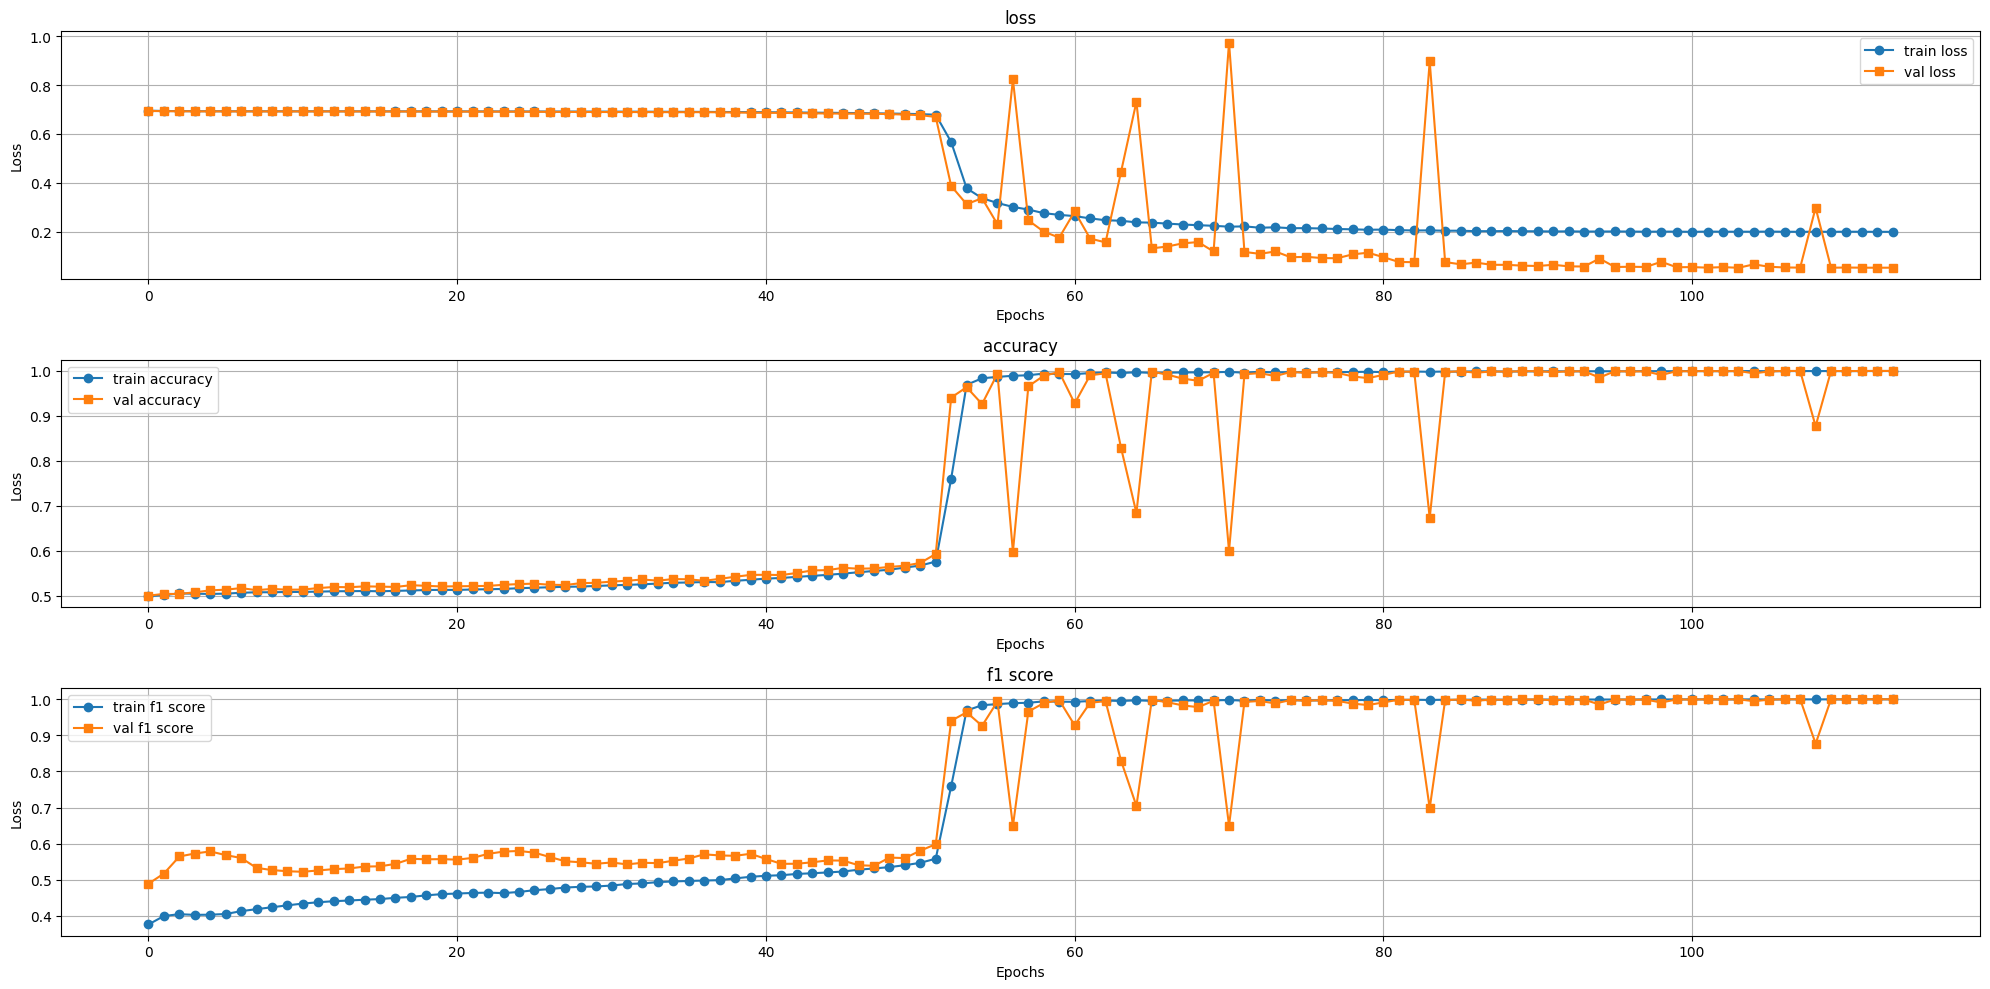

In [25]:
metrics = {
    "loss": {"train": train_losses, "val": val_losses},
    "accuracy": {"train": train_accuracies, "val": val_accuracies},
    "f1 score": {"train": train_f1_scores, "val": val_f1_scores},
}

show_metrics(metrics)


Модель успешно обучилась без явного переобучения. Результат: 0.99 f1_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

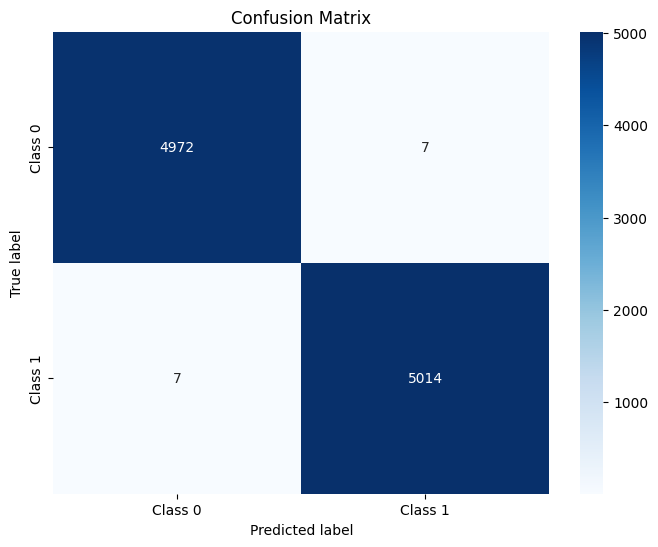

In [88]:
true_labels = []
predicted_labels = []
img1_errors = []
img2_errors = []
for img1, img2, gt in val_loader:
    true_labels.append(gt)
    model.eval()
    with torch.no_grad():
        logit = model(img1.to(device), img2.to(device)).detach().cpu()
        preds = (torch.sigmoid(logit) > 0.5).to(torch.int)
        predicted_labels.append(preds)
    mask = gt != preds
    if img1[mask].size()[0] > 0:
        img1_errors.append(img1[mask])
    if img2[mask].size()[0] > 0:
        img2_errors.append(img2[mask])

img1_errors = torch.cat(img1_errors, dim=0)
img2_errors = torch.cat(img2_errors, dim=0)
true_labels = torch.cat(true_labels, dim=0)
predicted_labels = torch.cat(predicted_labels, dim=0)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

Если вывести ошибки по матрице ошибок, можно заметить, что они возникали только в сложных случаях, когда цвет объекта практически сливается с фоном и трудно различим. В этих случаях скорее всего срабатывало просто среднее предсказание.

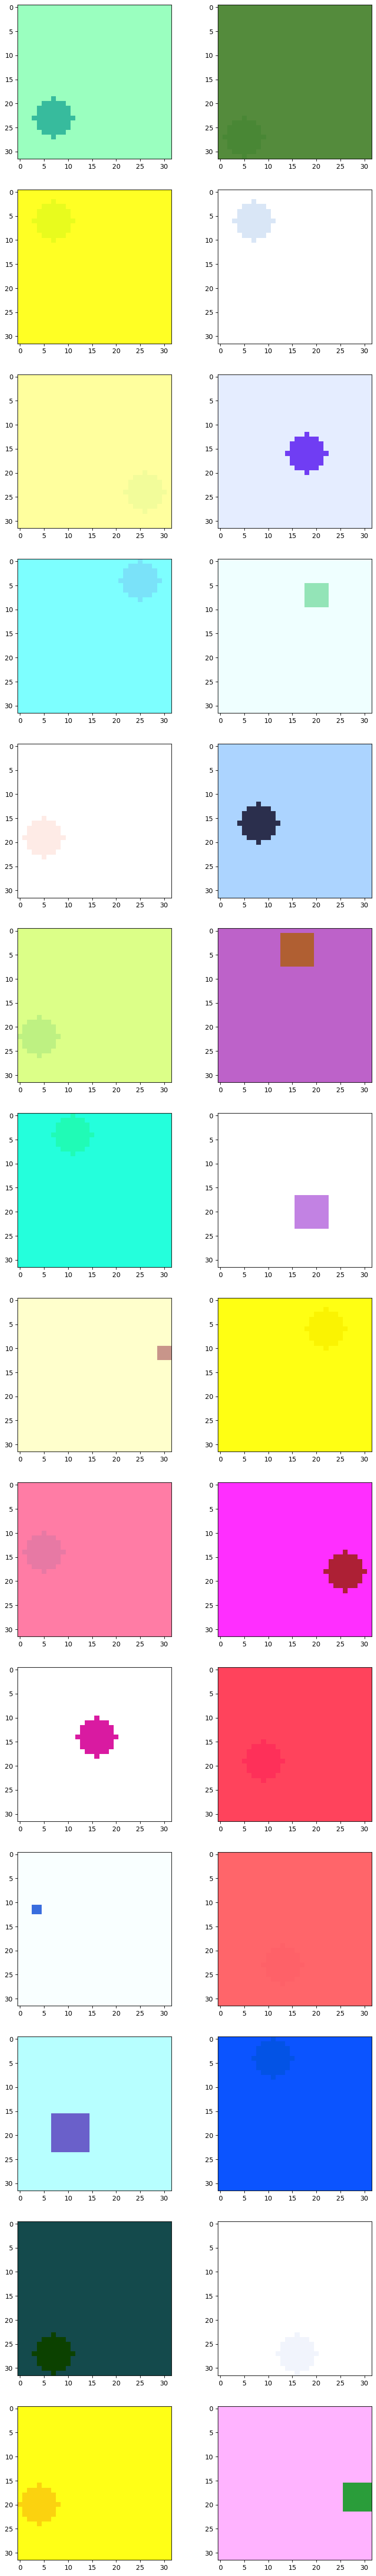

In [92]:
rows = img1_errors.size()[0]
fig, axs = plt.subplots(
    ncols=2,
    nrows=rows,
    figsize=(
        10,
        5 * rows,
    ),
)
for i, (img1, img2) in enumerate(zip(img1_errors, img2_errors)):
    axs[i][0].imshow(img1.permute(1, 2, 0))
    axs[i][1].imshow(img2.permute(1, 2, 0))

## Тесты

In [26]:
from torch.utils.data import DataLoader

In [27]:
from src.modeling.models import AGFusionModel
from src.plots import embedding_vis, visualize_pair_attention

In [28]:
model = AGFusionModel()
model.load_state_dict(torch.load("weights/AGFusion/AGFusionModel_best.pth"))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
None

/tmp/ipykernel_18884/1013844375.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/AGFusion/AGFusionModel_best.pth"))


In [94]:
test_ds = ShapePairDataset(num_samples=1000, mode="test")
test_loader = DataLoader(test_ds, batch_size=128)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


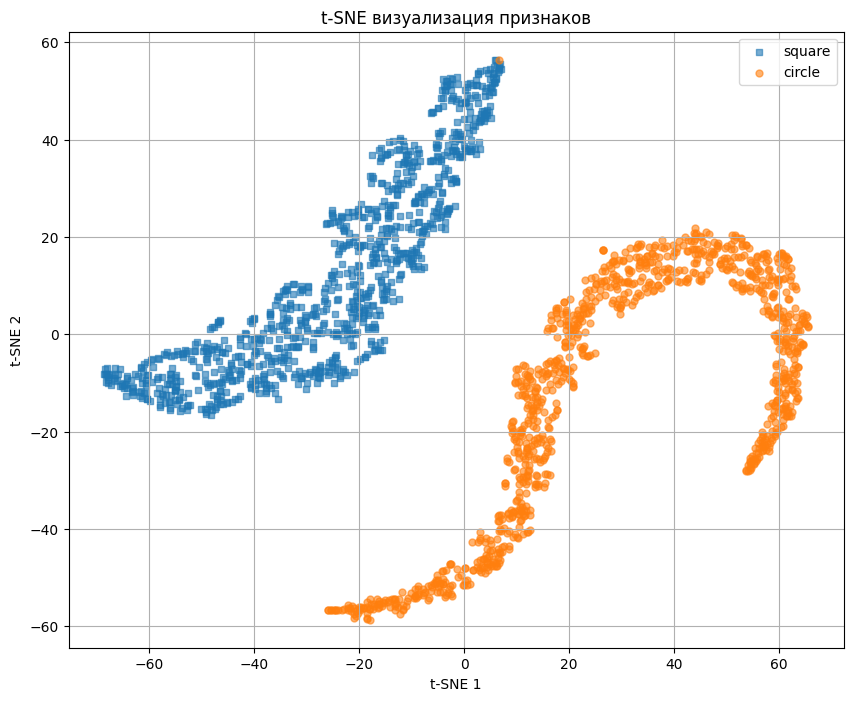

In [96]:
features = []
labels = []

embs1 = []
embs2 = []
shapes1 = []
shapes2 = []

model.eval()
with torch.no_grad():
    for img1, shape1, img2, shape2 in test_loader:
        emb1, emb2 = model.get_embeddings(img1.to(device), img2.to(device))
        # combined = torch.cat([emb1, emb2], dim=1)
        embs1.append(emb1.cpu())
        embs2.append(emb2.cpu())

        shapes1.append(shape1.cpu())
        shapes2.append(shape2.cpu())

embedding_vis(
    torch.cat(embs1).numpy(),
    torch.cat(shapes1).numpy(),
    torch.cat(embs2).numpy(),
    torch.cat(shapes2).numpy(),
)

Визуализация механизма внимания для поиска связей между признаками. Карты активаций получились довольно большими, по наборам карт можно заметить, что скорее всего слой много внимания обращает на пространственное положение, но при этом также имеет формы похожие на целевые фигуры при их совпадении и невнятные формы при несовпадении. Уточнить внимание можно заморозив слои feature_extractor, т.к возможно слой внимания не успевает переучиваться с изменением представлений при совместном обучении. Также есть подозрение, что проекция может строиться со смещением.

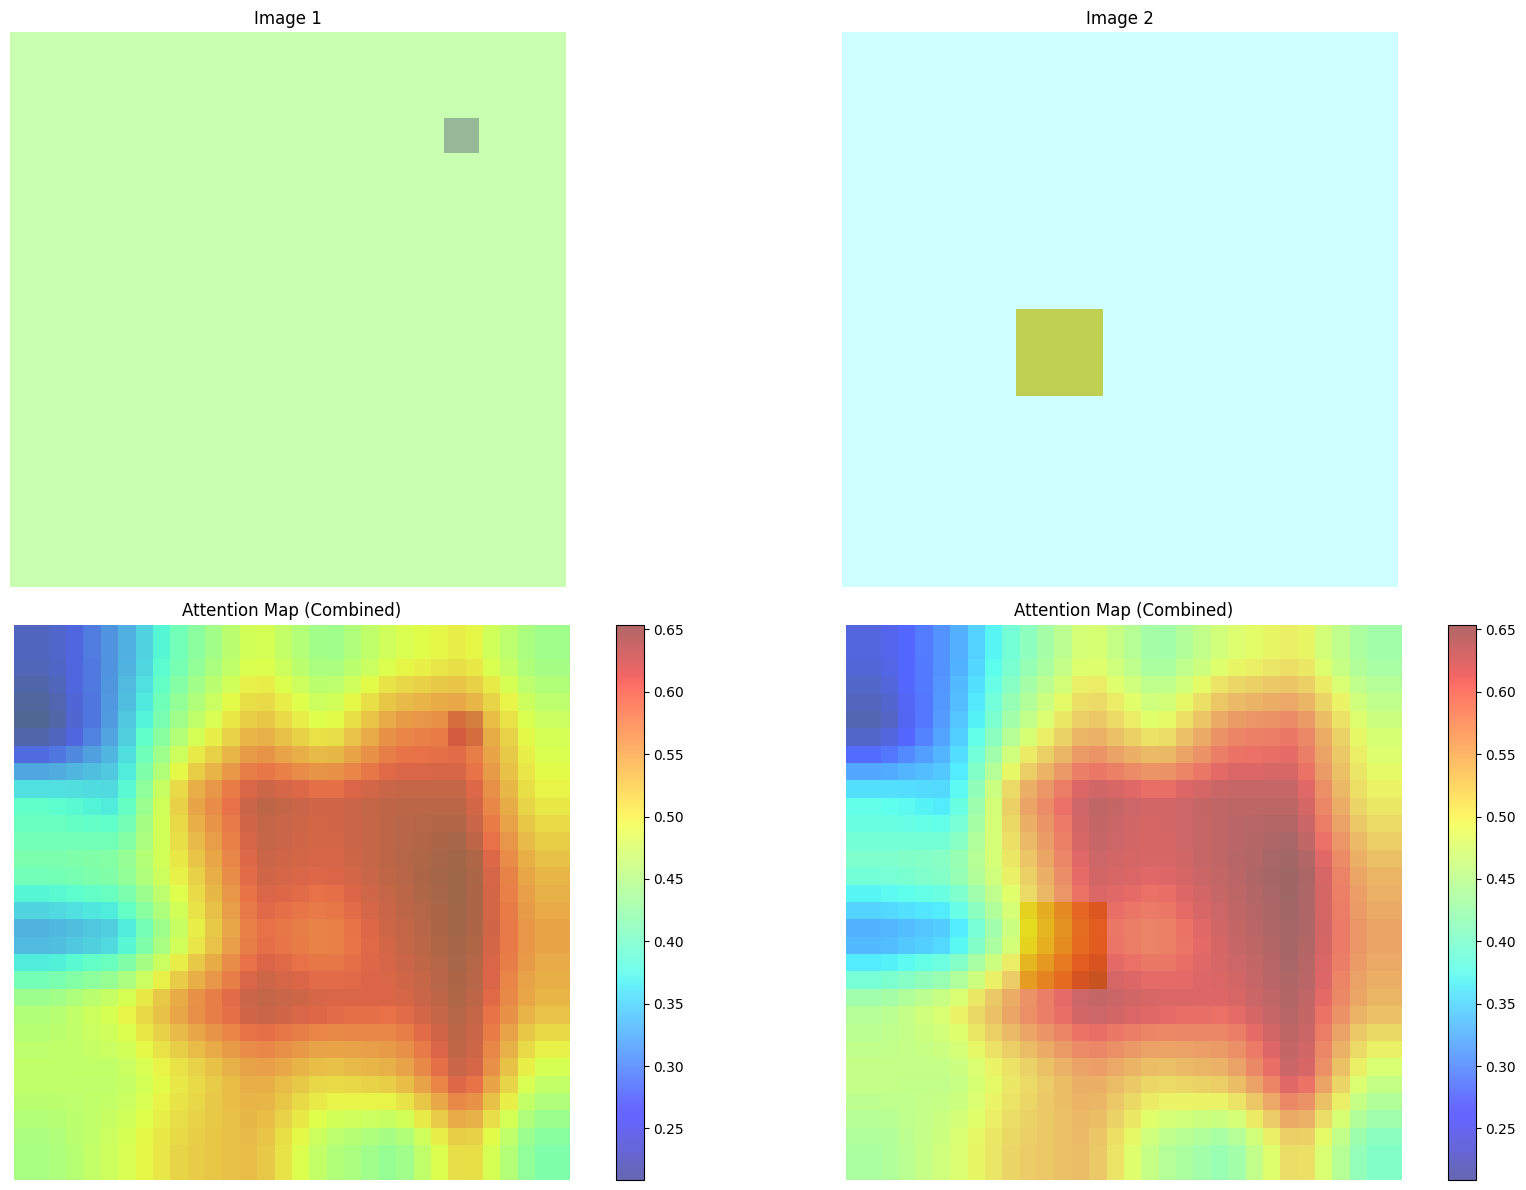

In [117]:
num = 16
model.eval()
with torch.no_grad():
    combined_att = model.attn_gate.get_attention_map(
        model.feature_extractor(img1.to(device)),
        model.feature_extractor(img2.to(device)),
        mode="combined",
    )
    spatial_att = model.attn_gate.get_attention_map(
        model.feature_extractor(img1.to(device)),
        model.feature_extractor(img2.to(device)),
        mode="spatial",
    )
    channel_att = model.attn_gate.get_attention_map(
        model.feature_extractor(img1.to(device)),
        model.feature_extractor(img2.to(device)),
        mode="channel",
    )
visualize_pair_attention(
    img1[num].detach(), img2[num].detach(), combined_att[num], mode="combined"
)

In [40]:
best_loss

0.0516476571559906

In [41]:
best_val_f1

0.9999004281589167